In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import random
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from src.model import Model
from src.dataloader import IMGDataset

In [3]:
MODEL_NAME = "gray_to_rgb_model.pth"
MODEL_PATH = os.path.join("..", "models", MODEL_NAME)

BASE_DIR = os.path.join("..", "data", "coco")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [4]:
IMG_SIZE = 64
BATCH_SIZE = 100
BLOCK_1_CHANNELS = 64
BLOCK_2_CHANNELS = 128
BLOCK_3_CHANNELS = 256
BLOCK_4_CHANNELS = 512
BOTTLENECK_CHANNELS = 1024

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
test_dataset = IMGDataset(TEST_DIR)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)

In [7]:
model = Model(
    BLOCK_1_CHANNELS, BLOCK_2_CHANNELS, BLOCK_3_CHANNELS, BLOCK_4_CHANNELS,
    BOTTLENECK_CHANNELS
).to(device)

In [8]:
model.load_state_dict(
    torch.load(MODEL_PATH, map_location=device)["model_state_dict"]
)

<All keys matched successfully>

In [9]:
model.eval()

psnr_total = 0.0
ssim_total = 0.0
num_images = 0

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Test"):
        x, y = x.to(device), y.to(device)
        outputs = model(x)

        outputs_norm = (outputs.cpu().numpy() + 1) / 2
        y_norm = (y.cpu().numpy() + 1) / 2

        for i in range(outputs_norm.shape[0]):
            out_img = np.transpose(outputs_norm[i], (1, 2, 0))
            tgt_img = np.transpose(y_norm[i], (1, 2, 0))

            psnr_total += peak_signal_noise_ratio(tgt_img, out_img, data_range=1.0)
            ssim_total += structural_similarity(tgt_img, out_img, channel_axis=2, data_range=1.0)
            num_images += 1

avg_psnr = psnr_total / num_images
avg_ssim = ssim_total / num_images

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}\n")

Test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [02:53<00:00,  2.34it/s]

Average PSNR: 23.88 dB
Average SSIM: 0.9112



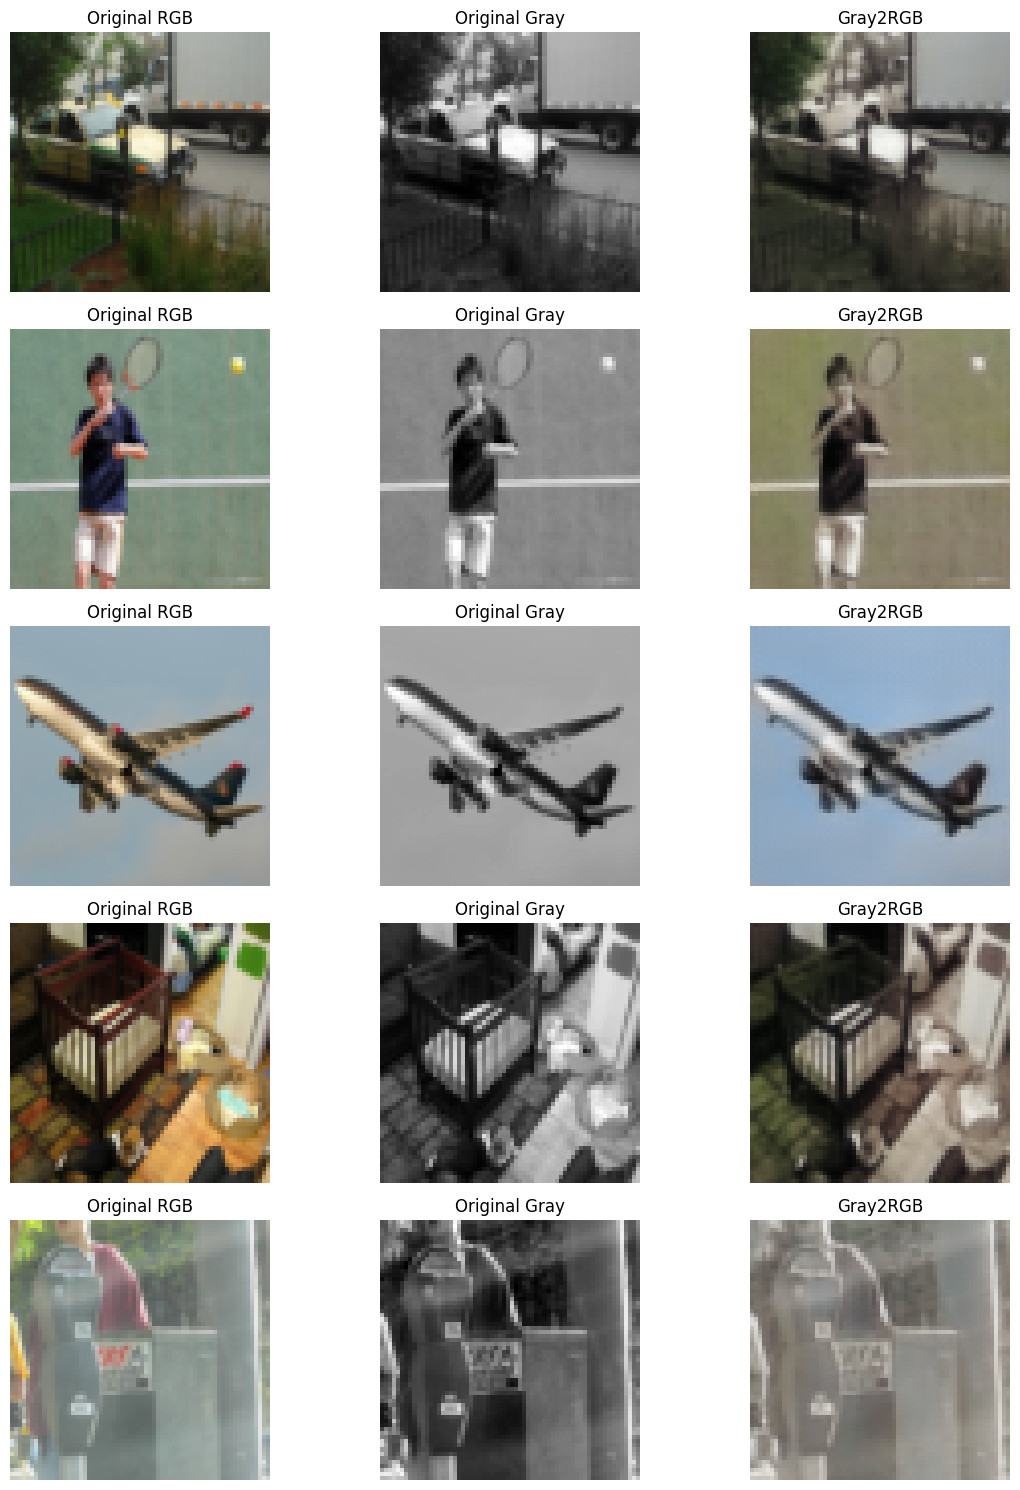

In [10]:
with torch.no_grad():
    x_gray, y_rgb = next(iter(test_loader))
    x_gray, y_rgb = x_gray.to(device), y_rgb.to(device)
    output_rgb = model(x_gray)

num_samples = 5
indices = random.sample(range(x_gray.size(0)), num_samples)

plt.figure(figsize=(12, num_samples * 3))

for i, idx in enumerate(indices):
    gray_img = x_gray[idx].cpu().squeeze().numpy()
    true_rgb = y_rgb[idx].cpu().permute(1, 2, 0).numpy()
    pred_rgb = output_rgb[idx].cpu().permute(1, 2, 0).numpy()

    pred_rgb = (pred_rgb + 1) / 2
    true_rgb = (true_rgb + 1) / 2
    gray_img = (gray_img + 1) / 2

    pred_rgb = np.clip(pred_rgb, 0, 1)
    true_rgb = np.clip(true_rgb, 0, 1)
    gray_img = np.clip(gray_img, 0, 1)

    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(true_rgb)
    plt.title("Original RGB")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(gray_img, cmap="gray")
    plt.title("Original Gray")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(pred_rgb)
    plt.title("Gray2RGB")
    plt.axis("off")

plt.tight_layout()
plt.show()